In [102]:
from raise_utils.interpret import DODGEInterpreter
from raise_utils.interpret.sk import Rx
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from numpy import array
import os
import re

In [26]:
tasks = ['defect prediction', 'issue close time']
treatments = ['none', 'weighted', 'wfo']
metrics = ['d2h', 'pd', 'pf', 'accuracy', 'f1']

In [4]:
files = os.listdir('./log')

In [8]:
defect_re = [re.findall('defect prediction[-](.*)[-](none|wfo|weighted).txt', x) for x in files]

In [9]:
defect_re = [x for x in defect_re if x != []]

In [11]:
defect_re = [x[0][0] for x in defect_re]

In [13]:
defect_re = list(set(defect_re))

In [14]:
defect_re

['camel',
 'lucene',
 'ivy',
 'xalan',
 'xerces',
 'poi',
 'jedit',
 'synapse',
 'velocity',
 'log4j']

In [15]:
issues_re = [re.findall('issue close time[-](.*)[-](none|wfo|weighted).txt', x) for x in files]

In [16]:
issues_re = [x[0][0] for x in issues_re if x != []]

In [18]:
issues_re = list(set(issues_re))

In [19]:
len(issues_re)

63

## Interpret defect prediction results

In [65]:
color_map = {'none': 1, 'weighted': 2, 'wfo': 3}

In [70]:
saved_data = pd.DataFrame(data={}, index=defect_re, columns=metrics, dtype=int)
for dataset in defect_re:
    print(dataset)
    print('=' * len(dataset))
    filename = f'./log/defect prediction-{dataset}'
    interpreter = DODGEInterpreter(
        files=[f'{filename}-none.txt', f'{filename}-weighted.txt', f'{filename}-wfo.txt'],
        metrics=metrics)
    results = interpreter.interpret()
    
    for metric in metrics:
        print(metric)
        print('=' * len(metric))
        perf_dict = {treatment: results[f'defect prediction-{dataset}-{treatment}.txt'][metric] for treatment in treatments}
        sk = Rx.sk(Rx.data(**perf_dict))
        Rx.show(sk)
        
        if metric != 'pf':
            saved_data.loc[dataset][metric] = color_map[sk[-1].rx]
        else:
            saved_data.loc[dataset][metric] = color_map[sk[0].rx]
        print()

camel
=====
d2h
===
   1       none (          -*--           |                        ), 0.204,  0.218,  0.226,  0.242,  0.284
   2        wfo (             -*          |                        ), 0.268,  0.274,  0.288,  0.309,  0.315
   3   weighted (              *          |                        ), 0.290,  0.294,  0.296,  0.298,  0.307

pd
==
   1       none (                -*----   |                        ), 0.298,  0.324,  0.340,  0.367,  0.457
   2   weighted (                         |  -*                    ), 0.527,  0.580,  0.590,  0.596,  0.617
   2        wfo (                         |  -*                    ), 0.564,  0.580,  0.596,  0.601,  0.612

pf
==
   1       none (      --*---             |                        ), 0.124,  0.138,  0.169,  0.188,  0.254
   2   weighted (                    *-   |                        ), 0.335,  0.403,  0.414,  0.421,  0.448
   3        wfo (                    -*   |                        ), 0.381,  0.407,  0.434,  0.441,  

d2h
===
   1       none (                --*---   |                        ), 0.323,  0.332,  0.373,  0.409,  0.449
   2   weighted (                   *     |                        ), 0.373,  0.384,  0.392,  0.400,  0.416
   3        wfo (                    *    |                        ), 0.402,  0.404,  0.406,  0.417,  0.421

pd
==
   1   weighted (                         |  -*-                   ), 0.566,  0.577,  0.591,  0.612,  0.626
   2       none (                         |  -*---                 ), 0.495,  0.573,  0.598,  0.633,  0.676
   3        wfo (                         |         *-             ), 0.708,  0.712,  0.715,  0.733,  0.758

pf
==
   1   weighted (      --*---             |                        ), 0.130,  0.137,  0.168,  0.217,  0.248
   2       none (         -*------        |                        ), 0.168,  0.180,  0.217,  0.261,  0.348
   3        wfo (               -*        |                        ), 0.280,  0.311,  0.323,  0.329,  0.348

accur

In [71]:
saved_data

,d2h,pd,pf,accuracy,f1
camel,2.0,3.0,1.0,1.0,2.0
lucene,2.0,1.0,3.0,2.0,1.0
ivy,1.0,1.0,2.0,2.0,3.0
xalan,3.0,3.0,2.0,3.0,3.0
xerces,3.0,3.0,1.0,3.0,3.0
poi,3.0,3.0,2.0,3.0,3.0
jedit,2.0,3.0,2.0,1.0,1.0
synapse,2.0,2.0,1.0,1.0,2.0
velocity,3.0,1.0,3.0,3.0,3.0
log4j,3.0,2.0,3.0,2.0,2.0


In [72]:
saved_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, camel to log4j
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   d2h       10 non-null     float64
 1   pd        10 non-null     float64
 2   pf        10 non-null     float64
 3   accuracy  10 non-null     float64
 4   f1        10 non-null     float64
dtypes: float64(5)
memory usage: 800.0+ bytes


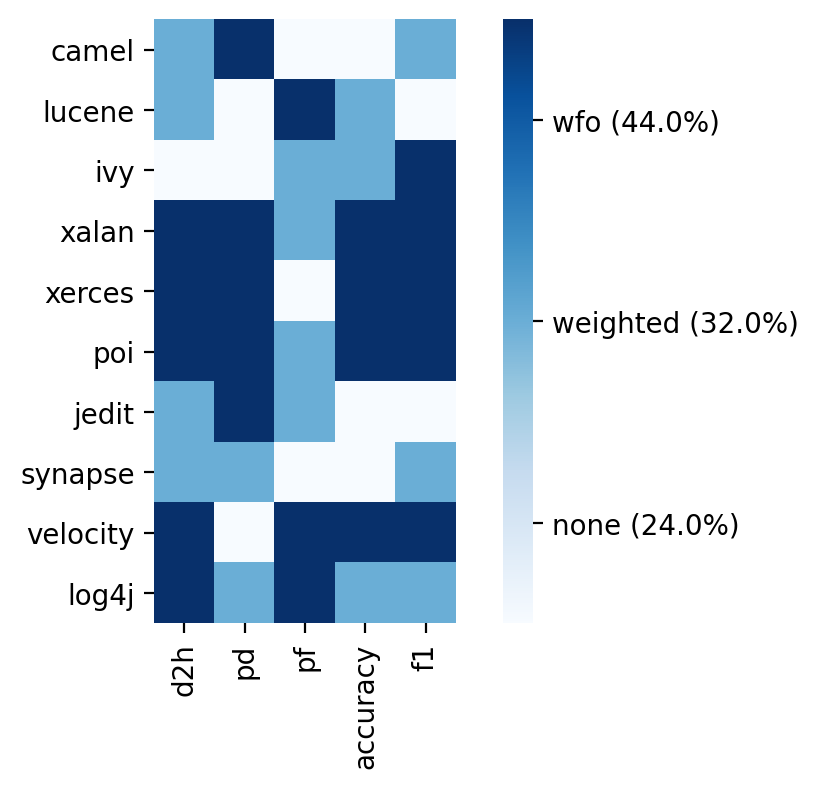

In [88]:
plt.figure(dpi=200)
ax = sns.heatmap(saved_data, square=True, cmap='Blues')

# From https://stackoverflow.com/a/56678411
n = 3
plt_total = (saved_data > 0).sum().sum()
vmap = {1: f'none ({100*round((saved_data == 1).sum().sum() / plt_total, 2)}%)', 
        2: f'weighted ({100*round((saved_data == 2).sum().sum() / plt_total, 2)}%)', 
        3: f'wfo ({100*round((saved_data == 3).sum().sum() / plt_total, 2)}%)'}
# Get the colorbar object from the Seaborn heatmap
colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))

## Interpret issue close time results

In [90]:
saved_data = pd.DataFrame(data={}, index=issues_re, columns=metrics, dtype=int)
for dataset in issues_re:
    print(dataset)
    print('=' * len(dataset))
    filename = f'./log/issue close time-{dataset}'
    interpreter = DODGEInterpreter(
        files=[f'{filename}-none.txt', f'{filename}-weighted.txt', f'{filename}-wfo.txt'],
        metrics=metrics)
    results = interpreter.interpret()
    
    for metric in metrics:
        print(metric)
        print('=' * len(metric))
        perf_dict = {treatment: results[f'issue close time-{dataset}-{treatment}.txt'][metric] for treatment in treatments}
        sk = Rx.sk(Rx.data(**perf_dict))
        Rx.show(sk)
        
        if metric != 'pf':
            saved_data.loc[dataset][metric] = color_map[sk[-1].rx]
        else:
            saved_data.loc[dataset][metric] = color_map[sk[0].rx]
        print()

camel-30 days
d2h
===
   1       none (            *-           |                        ), 0.234,  0.251,  0.254,  0.258,  0.282
   2   weighted (                    *    |                        ), 0.405,  0.410,  0.411,  0.416,  0.428
   3        wfo (                      *  |                        ), 0.439,  0.447,  0.449,  0.455,  0.468

pd
==
   1       none (                  --*    |                        ), 0.360,  0.380,  0.420,  0.440,  0.440
   2   weighted (                         |           *-           ), 0.745,  0.745,  0.745,  0.766,  0.787
   3        wfo (                         |            *           ), 0.721,  0.767,  0.767,  0.791,  0.791

pf
==
   1       none (            -*-          |                        ), 0.027,  0.252,  0.268,  0.293,  0.319
   2        wfo (             -*          |                        ), 0.245,  0.265,  0.282,  0.298,  0.304
   3   weighted (                *        |                        ), 0.325,  0.330,  0.333,  0.338,

d2h
===
   1       none (                *---     |                        ), 0.308,  0.324,  0.337,  0.381,  0.408
   2   weighted (                    *    |                        ), 0.400,  0.404,  0.404,  0.406,  0.438
   3        wfo (                     *   |                        ), 0.420,  0.424,  0.431,  0.436,  0.450

pd
==
   1        wfo (                         |     *----              ), 0.614,  0.628,  0.628,  0.669,  0.731
   1       none (                         |   ---*-----            ), 0.587,  0.594,  0.645,  0.754,  0.768
   2   weighted (                         |        *---            ), 0.692,  0.692,  0.692,  0.699,  0.760

pf
==
   1        wfo (    *---------           |                        ), 0.070,  0.088,  0.094,  0.141,  0.295
   2   weighted (              *          |                        ), 0.290,  0.295,  0.298,  0.304,  0.313
   3       none (                 --*--   |                        ), 0.308,  0.345,  0.384,  0.398,  0.456

accur

   1   weighted (                   *     |                        ), 0.376,  0.384,  0.388,  0.390,  0.414
   2       none (                      *- |                        ), 0.418,  0.443,  0.452,  0.456,  0.497
   3        wfo (                         |    *                   ), 0.565,  0.607,  0.615,  0.623,  0.633

cloudstack-90 days
d2h
===
   1       none (               *-        |                        ), 0.284,  0.304,  0.318,  0.337,  0.343
   2        wfo (                  *-     |                        ), 0.371,  0.378,  0.380,  0.388,  0.412
   2   weighted (                  -*-    |                        ), 0.360,  0.369,  0.390,  0.416,  0.437

pd
==
   1       none (                       -*|--                      ), 0.406,  0.469,  0.500,  0.531,  0.562
   2        wfo (                         |        *---            ), 0.686,  0.686,  0.686,  0.743,  0.771
   3   weighted (                         |          -*--          ), 0.697,  0.727,  0.758,  0.788, 

   1       none (      *                  |                        ), 0.119,  0.123,  0.136,  0.145,  0.149
   2        wfo (        *                |                        ), 0.158,  0.167,  0.169,  0.172,  0.190
   3   weighted (         *               |                        ), 0.160,  0.183,  0.192,  0.196,  0.208

hive-1 day
d2h
===
   1       none (     *-----              |                        ), 0.000,  0.118,  0.118,  0.118,  0.236
   2        wfo (                      -*-|--------                ), 0.296,  0.448,  0.463,  0.684,  0.687
   2   weighted (                       *-|-------                 ), 0.463,  0.466,  0.468,  0.471,  0.661

pd
==
   1       none (        *-------         |                        ), 0.000,  0.167,  0.167,  0.167,  0.333
   2   weighted (                         |       *--------------- ), 0.667,  0.667,  0.667,  0.667,  1.000
   3        wfo (                         |           *----------- ), 0.500,  0.750,  0.750,  1.000,  1.000



d2h
===
   1       none (           ------*       |                        ), 0.235,  0.236,  0.351,  0.353,  0.353
   2   weighted (                      -*-|                        ), 0.446,  0.450,  0.472,  0.516,  0.540
   3        wfo (                         | *-                     ), 0.502,  0.550,  0.558,  0.570,  0.591

pd
==
   1       none (                --------*|                        ), 0.333,  0.333,  0.500,  0.500,  0.500
   2   weighted (                         |               --------*), 0.833,  0.833,  1.000,  1.000,  1.000
   2        wfo (                         |                       *), 1.000,  1.000,  1.000,  1.000,  1.000

pf
==
   1       none (-*-                      |                        ), 0.008,  0.016,  0.024,  0.055,  0.068
   2        wfo (          *----          |                        ), 0.167,  0.204,  0.211,  0.258,  0.303
   3   weighted (         -------*-       |                        ), 0.165,  0.199,  0.327,  0.361,  0.369

accur

d2h
===
   1       none (             *           |                        ), 0.274,  0.277,  0.278,  0.280,  0.283
   2        wfo (                *        |                        ), 0.326,  0.334,  0.339,  0.352,  0.360
   3   weighted (                 *       |                        ), 0.345,  0.349,  0.353,  0.360,  0.365

pd
==
   1       none (                       -*|                        ), 0.470,  0.476,  0.485,  0.494,  0.515
   2        wfo (                        -*---                     ), 0.483,  0.498,  0.510,  0.548,  0.586
   3   weighted (                         |    -*-                 ), 0.607,  0.619,  0.636,  0.669,  0.678

pf
==
   1        wfo (     *-----------        |                        ), 0.090,  0.102,  0.106,  0.111,  0.347
   2       none (               -*-       |                        ), 0.288,  0.303,  0.325,  0.339,  0.366
   3   weighted (                -*       |                        ), 0.318,  0.334,  0.352,  0.363,  0.370

accur

d2h
===
   1       none (                -*       |                        ), 0.323,  0.340,  0.340,  0.342,  0.365
   2        wfo (                    -*---|--                      ), 0.404,  0.407,  0.433,  0.555,  0.565
   3   weighted (                        -*-                       ), 0.441,  0.498,  0.505,  0.544,  0.559

pd
==
   1       none (                        *|----------------------- ), 0.458,  0.500,  0.500,  0.500,  1.000
   2   weighted (                         |             *------    ), 0.643,  0.786,  0.786,  0.929,  0.929
   3        wfo (                         |             -----*--   ), 0.700,  0.800,  0.900,  0.900,  0.950

pf
==
   1       none (      *----------------- |                        ), 0.045,  0.135,  0.137,  0.162,  0.484
   2   weighted (         *               |                        ), 0.161,  0.181,  0.197,  0.203,  0.219
   3        wfo (          ------*---     |                        ), 0.191,  0.203,  0.331,  0.360,  0.413

accur

d2h
===
   1       none (                 -*      |                        ), 0.348,  0.352,  0.363,  0.368,  0.376
   1   weighted (                 -*-     |                        ), 0.324,  0.352,  0.365,  0.393,  0.410
   2        wfo (                  -*     |                        ), 0.333,  0.377,  0.388,  0.392,  0.401

pd
==
   1        wfo (                         |           *-           ), 0.707,  0.746,  0.759,  0.772,  0.784
   2   weighted (                         |          ---*--        ), 0.693,  0.734,  0.795,  0.807,  0.840
   3       none (                         |             -*         ), 0.743,  0.789,  0.802,  0.823,  0.835

pf
==
   1        wfo (                  --*--  |                        ), 0.362,  0.378,  0.402,  0.417,  0.465
   2   weighted (                   --*-  |                        ), 0.330,  0.400,  0.426,  0.461,  0.478
   3       none (                     -*  |                        ), 0.418,  0.434,  0.451,  0.459,  0.475

accur

d2h
===
   1        wfo (                         | *                      ), 0.537,  0.541,  0.543,  0.545,  0.568
   2       none (                         | *-                     ), 0.543,  0.550,  0.557,  0.583,  0.587
   3   weighted (                         | *                      ), 0.538,  0.548,  0.558,  0.567,  0.570

pd
==
   1   weighted (                         |              *         ), 0.796,  0.808,  0.819,  0.830,  0.840
   2       none (                         |              -*-       ), 0.806,  0.816,  0.828,  0.853,  0.867
   3        wfo (                         |                   *    ), 0.872,  0.901,  0.907,  0.909,  0.913

pf
==
   1   weighted (     *                   |                        ), 0.098,  0.109,  0.113,  0.120,  0.129
   1       none (     *                   |                        ), 0.101,  0.109,  0.118,  0.125,  0.130
   2        wfo (          *              |                        ), 0.193,  0.205,  0.211,  0.215,  0.223

accur

d2h
===
   1       none (     *                   |                        ), 0.080,  0.100,  0.106,  0.112,  0.126
   2   weighted (           *-            |                        ), 0.228,  0.232,  0.235,  0.246,  0.262
   2        wfo (           -*            |                        ), 0.227,  0.235,  0.241,  0.243,  0.265

pd
==
   1       none (       *-                |                        ), 0.119,  0.148,  0.156,  0.163,  0.185
   2   weighted (                       *-|----                    ), 0.459,  0.467,  0.474,  0.511,  0.607
   3        wfo (                         |*-                      ), 0.500,  0.516,  0.533,  0.541,  0.566

pf
==
   1       none (    *                    |                        ), 0.078,  0.087,  0.092,  0.096,  0.109
   2   weighted (                    -*-- |                        ), 0.395,  0.411,  0.421,  0.431,  0.493
   3        wfo (                     --* |                        ), 0.410,  0.421,  0.469,  0.483,  0.492

accur

d2h
===
   1       none (                  *---   |                        ), 0.356,  0.362,  0.376,  0.413,  0.449
   2        wfo (                      *--|                        ), 0.444,  0.450,  0.460,  0.473,  0.516
   3   weighted (                        *|                        ), 0.471,  0.487,  0.491,  0.493,  0.525

pd
==
   1       none (                         |      -*-----           ), 0.571,  0.643,  0.667,  0.714,  0.786
   2   weighted (                         |          -*            ), 0.694,  0.722,  0.750,  0.750,  0.778
   3        wfo (                         |          --*-          ), 0.651,  0.721,  0.767,  0.791,  0.814

pf
==
   1   weighted (        *                |                        ), 0.020,  0.165,  0.173,  0.180,  0.190
   2        wfo (  ------------*          |                        ), 0.028,  0.059,  0.286,  0.299,  0.310
   3       none (            ---*---      |                        ), 0.180,  0.251,  0.311,  0.342,  0.388

accur

In [94]:
saved_data

,d2h,pd,pf,accuracy,f1
camel-30 days,3.0,3.0,1.0,3.0,3.0
cloudstack-1 day,1.0,3.0,1.0,1.0,2.0
qpid-30 days,2.0,1.0,3.0,3.0,3.0
cloudstack-30 days,1.0,1.0,1.0,1.0,1.0
camel-1 day,2.0,2.0,3.0,3.0,3.0
...,...,...,...,...,...
hive-30 days,2.0,3.0,2.0,2.0,2.0
node-7 days,2.0,2.0,3.0,3.0,3.0
qpid-180 days,3.0,2.0,1.0,3.0,3.0
camel-180 days,3.0,3.0,1.0,3.0,3.0


In [103]:
colors = [matplotlib.cm.Blues(x / 3) for x in range(3)]

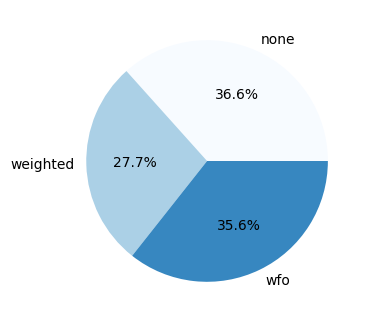

In [105]:
plt.figure(dpi=100)
plt.pie([100*round((saved_data == i).sum().sum() / plt_total, 2) for i in range(1, 4)],
        labels=treatments,
        autopct='%1.1f%%',
        colors=colors);